In [1]:
import pandas as pd
from thoughtfulness_features import *
import os
from nltk.corpus import PlaintextCorpusReader
from nltk import word_tokenize

# Read labelled data

In [2]:
path_parent = os.path.dirname(os.path.dirname(os.getcwd()))
file_path = f'{path_parent}/Data/Thoughtful Comments/thoughtful_comments_labelled.csv'

# Create thoughtful comment features

In [3]:
df = pd.read_csv(file_path)
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [4]:
df.head()

,Comment,Thoughtful?,Topic
0,Even watching the forbidden p0rn vids are ille...,0,Tracetogether
1,OP make a lot of claims without pointing out t...,0,Tracetogether
2,*pretends to be shocked*,0,Tracetogether
3,"Credit where credit is due, he clearly says Tr...",0,Tracetogether
4,got RTX 3080 anot??,0,Tracetogether


In [5]:
df['Thoughtful?'].sum()

153

## Ceating Feature 1

In [6]:
# Creating feature 1 (Structural feature): comment length
comment_length = []
for row in df['Comment']:
    length = get_comment_length(row)
    comment_length.append(length)
df['Length'] = comment_length

### Drop rows with comment length == 0

In [7]:
# Removing rows with zero comment length before creating features 2 to 5
df.drop(df[df.Length == 0].index, inplace=True)

# Creating Features 2 to 4

In [8]:
# Preparation for feature 2 (Lexical feature): comment likelihood
comment_likelihood = []
news_unigram = news_articles_unigram(f'{path_parent}/Data/News Article/articles1.csv')

# Preparation for feature 3 (Syntatic feature): number of verbs
num_verbs = []

# Preparation for feature 4 (Discourse feature): number of discourse relations
num_discourse_relations = []

for row in df['Comment']:
    # Creating feature 2 
    cmt_text_counter = comment_unicounter(row)
    cmt_loglikelihood = news_unigram.evaluate(cmt_text_counter)
    comment_likelihood.append(cmt_loglikelihood)

    # Creating feature 3
    verbs_count = get_num_verbs(row)
    num_verbs.append(verbs_count)

    # Creating feature 4
    discourse_count = num_discourse(row)
    num_discourse_relations.append(discourse_count)

df['Average Loglikelihood'] = comment_likelihood
df['Num Verbs'] = num_verbs
df['Num Discourse Relations'] = num_discourse_relations

In [9]:
df.head()

,Comment,Thoughtful?,Topic,Length,Average Loglikelihood,Num Verbs,Num Discourse Relations
0,Even watching the forbidden p0rn vids are ille...,0,Tracetogether,28,-12.470231,6,1
1,OP make a lot of claims without pointing out t...,0,Tracetogether,27,-11.514518,6,1
2,*pretends to be shocked*,0,Tracetogether,4,-10.466185,2,0
3,"Credit where credit is due, he clearly says Tr...",0,Tracetogether,17,-11.904904,5,1
4,got RTX 3080 anot??,0,Tracetogether,4,-18.174303,1,0


# Creating Feature 5

### Reading all the policy docs into a corpus

In [10]:
corpus = PlaintextCorpusReader(f'{path_parent}/Data/Policy Documents/', '.+\.txt', encoding='utf-8')

In [11]:
fid = corpus.fileids()
fid.sort()

In [12]:
doc_words = [corpus.words(f) for f in fid]

In [13]:
fid

['circuit_breaker_policy.txt',
 'safe_distancing_policy.txt',
 'tracetogether_policy.txt',
 'vaccination_policy.txt']

### Splitting the labelled data to its own policy/topic

In [14]:
circuit_breaker_comments = df[df['Topic'] == 'circuit breaker']
safe_distancing_comments = df[df['Topic'] == 'safe distancing']
tracetogether_comments = df[df['Topic'] == 'Tracetogether']
vaccination_comments = df[df['Topic'] == 'vaccination']
comments = [circuit_breaker_comments, safe_distancing_comments, tracetogether_comments, vaccination_comments]

### Calculating KL-divergence relevance score for each comment to its respective policy topic

In [15]:
for i in range(4):
    doc_unigram, doc_nouns = topic_doc_unigram(doc_words[i], k=1)
    relavance_scores = []
    for row in comments[i]['Comment']:
        cmt_unigram, cmt_nouns = comment_unigram(row, k=1)
        score = KLDiv_relevance_score(doc_unigram, cmt_unigram, doc_nouns, cmt_nouns)
        relavance_scores.append(score)
    comments[i]['Relevance score'] = relavance_scores

In [16]:
df_final = pd.concat(comments, ignore_index=True)

In [17]:
df_final['Relevance score'].min()

0.020731665275518923

In [18]:
df_final['Relevance score'].max()

7.5

In [19]:
df_final.head()

,Comment,Thoughtful?,Topic,Length,Average Loglikelihood,Num Verbs,Num Discourse Relations,Relevance score
0,🇸🇬New Parc Clematis National Day Promo startin...,0,circuit breaker,34,-13.944796,4,1,0.394303
1,"Oh my fucking God, this announcement could not...",0,circuit breaker,94,-11.286315,16,5,0.305200
2,Dang it. I was super happy for a while.\n\nIt'...,0,circuit breaker,18,-9.626479,3,2,1.482839
3,After a beautiful front 9 we got hit with the ...,0,circuit breaker,11,-13.549426,2,0,0.811136
4,"these people must be tagged, if not cannot ent...",0,circuit breaker,11,-11.213937,2,1,1.674952


In [20]:
df_final.to_csv(f'{path_parent}/Data/Thoughtful Comments/thoughtful_comments_final.csv')

# Training the classification model

In [21]:
### Basic Imports
import pandas as pd
import numpy as np

### Graphic libraries
import matplotlib.pyplot as plt
import seaborn as sns 


### Importing the relevant ML libraries 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_score

from sklearn.metrics import accuracy_score,roc_curve,auc,recall_score,f1_score,precision_score,classification_report,confusion_matrix,auc

In [22]:
df = pd.read_csv(f'{path_parent}/Data/Thoughtful Comments/thoughtful_comments_final.csv')

In [23]:
df.head()

,Unnamed: 0,Comment,Thoughtful?,Topic,Length,Average Loglikelihood,Num Verbs,Num Discourse Relations,Relevance score
0,0,🇸🇬New Parc Clematis National Day Promo startin...,0,circuit breaker,34,-13.944796,4,1,0.394303
1,1,"Oh my fucking God, this announcement could not...",0,circuit breaker,94,-11.286315,16,5,0.305200
2,2,Dang it. I was super happy for a while.\n\nIt'...,0,circuit breaker,18,-9.626479,3,2,1.482839
3,3,After a beautiful front 9 we got hit with the ...,0,circuit breaker,11,-13.549426,2,0,0.811136
4,4,"these people must be tagged, if not cannot ent...",0,circuit breaker,11,-11.213937,2,1,1.674952


In [24]:
features_list = ['Length', 'Average Loglikelihood', 'Num Verbs', 'Num Discourse Relations', 'Relevance score']
target = 'Thoughtful?'

In [25]:
# Function to plot distribution graphs

def eda_plots(df,features_list,plot_title,fig_size):

    df[features_list].hist(bins=40,edgecolor='b',linewidth=1.0,xlabelsize=8,ylabelsize=8,grid= False,figsize=fig_size ,color='red')

    plt.tight_layout(rect=(0,0,1.2,1.2))

    # Overall title for all the plots
    plt.suptitle(plot_title,x=0.65,y=1.25,fontsize=14)

    plt.show()

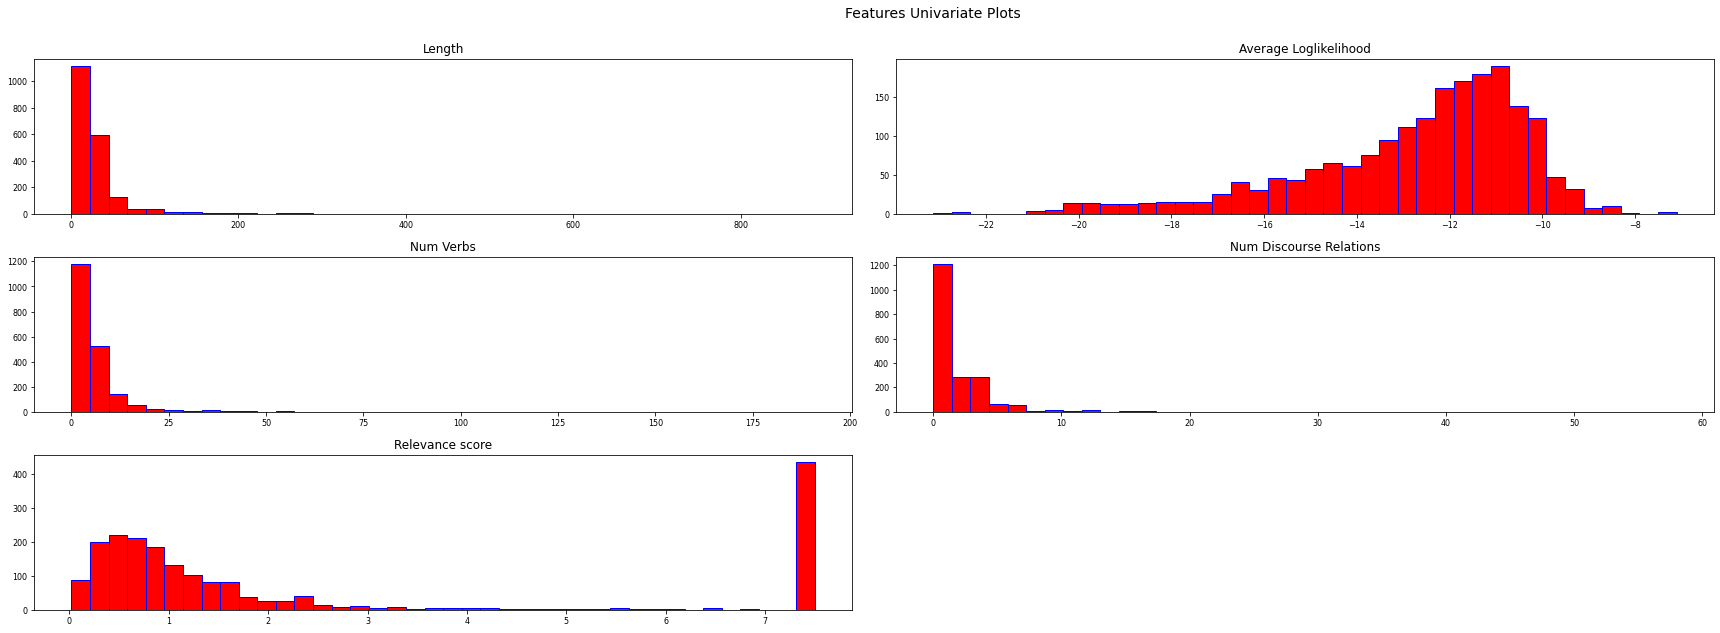

In [26]:
eda_plots(df,features_list,'Features Univariate Plots',(20,7))

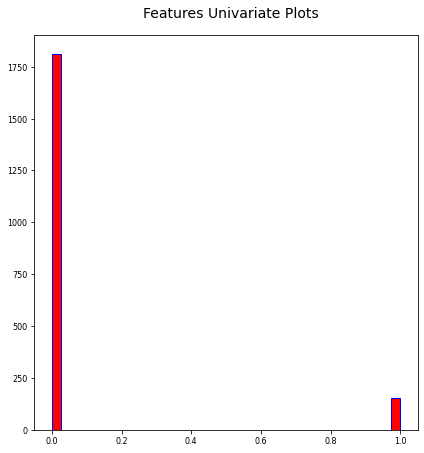

In [27]:
eda_plots(df,target,'Features Univariate Plots',(5,5))

# Training of classficiation model

In [28]:
models_dict = {
    'Logistic Regression':LogisticRegression(),
    'Naive Bayes':GaussianNB(),
    'Decision Trees':DecisionTreeClassifier(),
    'SVM linear': svm.SVC(kernel='linear'),
    'SVM rbf': svm.SVC(kernel='rbf'),
    'Random Forest': RandomForestClassifier(n_estimators = 100),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False)
}

performance_data = {}

In [29]:
# Creating our independent and dependent variables df
x = df[['Length', 'Average Loglikelihood', 'Num Verbs', 'Num Discourse Relations', 'Relevance score']]
y = df['Thoughtful?']

# Perform train test split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=15) 
# X_train.shape, X_test.shape, y_train.shape, y_test.shape

model_acc_score = [] # store all the model acc scores 
performance_data = {
    'accuracy':[],
    'precision':[],
    'recall':[],
    'f1':[]
} # store acc, precision, recall, f1 score 

# Training with differnent models
for model_name in models_dict:
    m = models_dict[model_name]
    
    m.fit(X_train, y_train)
    predictions = m.predict(X_test)

    acc = accuracy_score(y_test,predictions)  # always true label first, then your predicted labels!
    model_acc_score.append((model_name, acc))

    precision = precision_score(y_test,predictions) 
    recall = recall_score(y_test,predictions) 
    f1 = f1_score(y_test,predictions)

    # adding into the performance data dict
    performance_data['accuracy'].append(acc)
    performance_data['precision'].append(precision)
    performance_data['recall'].append(recall)
    performance_data['f1'].append(f1)

    print(model_name)
    print('-'*50)
    print('Accuracy Score for {} is {:.5f}'.format(model_name,acc))
    print('Precision Score for {} is {:.5f}'.format(model_name,precision))
    print('Recall Score for {} is {:.5f}'.format(model_name,recall))
    print('F1 Score for {} is {:.5f}'.format(model_name,f1))
    print()

Logistic Regression
--------------------------------------------------
Accuracy Score for Logistic Regression is 0.93209
Precision Score for Logistic Regression is 0.66667
Recall Score for Logistic Regression is 0.26087
F1 Score for Logistic Regression is 0.37500

Naive Bayes
--------------------------------------------------
Accuracy Score for Naive Bayes is 0.92530
Precision Score for Naive Bayes is 0.52500
Recall Score for Naive Bayes is 0.45652
F1 Score for Naive Bayes is 0.48837

Decision Trees
--------------------------------------------------
Accuracy Score for Decision Trees is 0.89474
Precision Score for Decision Trees is 0.34615
Recall Score for Decision Trees is 0.39130
F1 Score for Decision Trees is 0.36735

SVM linear
--------------------------------------------------
Accuracy Score for SVM linear is 0.92869
Precision Score for SVM linear is 0.70000
Recall Score for SVM linear is 0.15217
F1 Score for SVM linear is 0.25000

SVM rbf
------------------------------------------

# Stratified K-Fold Sampling

In [30]:
skf = StratifiedKFold(n_splits=10)
target = df['Thoughtful?']

In [31]:
fold_no = 1
for train_index, test_index in skf.split(df, target):
    train = df.loc[train_index,:]
    test = df.loc[test_index,:]
    print('Fold',str(fold_no),
          'Class Ratio:',
          sum(test['Thoughtful?'])/len(test['Thoughtful?']))
    fold_no += 1

Fold 1 Class Ratio: 0.08121827411167512
Fold 2 Class Ratio: 0.08121827411167512
Fold 3 Class Ratio: 0.08121827411167512
Fold 4 Class Ratio: 0.07653061224489796
Fold 5 Class Ratio: 0.07653061224489796
Fold 6 Class Ratio: 0.07653061224489796
Fold 7 Class Ratio: 0.07653061224489796
Fold 8 Class Ratio: 0.07653061224489796
Fold 9 Class Ratio: 0.07653061224489796
Fold 10 Class Ratio: 0.07653061224489796


In [32]:
skf = StratifiedKFold(n_splits=10)

X = ['Length', 'Average Loglikelihood', 'Num Verbs', 'Num Discourse Relations', 'Relevance score']
y = ['Thoughtful?']

model = LogisticRegression()
best_acc = 0
best_train_set = []
best_test_set = []

fold_no = 1
for train_index, test_index in skf.split(df, target):
    train = df.loc[train_index,:]
    test = df.loc[test_index,:]
    
    X_train = train[X]
    y_train = train[y]
    X_test = test[X]
    y_test = test[y]
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    if accuracy_score(y_test,predictions) > best_acc:
        best_acc = accuracy_score(y_test,predictions)
        best_train_set = train
        best_test_set = test
    print('Fold', str(fold_no), 'Accuracy:', accuracy_score(y_test,predictions))

    fold_no += 1

Fold 1 Accuracy: 0.9289340101522843
Fold 2 Accuracy: 0.9137055837563451
Fold 3 Accuracy: 0.9289340101522843
Fold 4 Accuracy: 0.9489795918367347
Fold 5 Accuracy: 0.9744897959183674
Fold 6 Accuracy: 0.9438775510204082
Fold 7 Accuracy: 0.9132653061224489
Fold 8 Accuracy: 0.9183673469387755
Fold 9 Accuracy: 0.9285714285714286
Fold 10 Accuracy: 0.9336734693877551


## Cross Validation

In [33]:
X = df[['Length', 'Average Loglikelihood', 'Num Verbs', 'Num Discourse Relations', 'Relevance score']]
y = df[['Thoughtful?']]

In [34]:
for model_name in models_dict:
    m = models_dict[model_name]
    scoring = ['accuracy', 'precision', 'recall', 'f1']
    scores = cross_validate(m, X, y, scoring=scoring, cv=10)

    print(model_name)
    print('-'*50)
    print(f"Mean accuracy is {scores['test_accuracy'].mean()}")
    print(f"Mean precision is {scores['test_precision'].mean()}")
    print(f"Mean recall is {scores['test_recall'].mean()}")
    print(f"Mean f1 is {scores['test_f1'].mean()}")
    print()
    print()

Logistic Regression
--------------------------------------------------
Mean accuracy is 0.9332798093856833
Mean precision is 0.7021212121212121
Mean recall is 0.2829166666666667
Mean f1 is 0.3799679873901842


Naive Bayes
--------------------------------------------------
Mean accuracy is 0.927667564487724
Mean precision is 0.5634254050043523
Mean recall is 0.49874999999999997
Mean f1 is 0.5160025309741675


Decision Trees
--------------------------------------------------
Mean accuracy is 0.8955635553713872
Mean precision is 0.3505336899942163
Mean recall is 0.36750000000000005
Mean f1 is 0.3527694446954409


SVM linear
--------------------------------------------------
Mean accuracy is 0.929713560551124
Mean precision is 0.7256349206349206
Mean recall is 0.19124999999999998
Mean f1 is 0.2875210195721032


SVM rbf
--------------------------------------------------
Mean accuracy is 0.9297187402879933
Mean precision is 0.6634920634920636
Mean recall is 0.2704166666666667
Mean f1 is 0.36

From the cross validation, with 10 stratified k-folds, naives bayes classifier seems to be the best one based on highest recall score and f1 score.

# Perform Random Forest Feature Selection to look at importance of each features

In [35]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

In [36]:
df = pd.read_csv(f'{path_parent}/Data/Thoughtful Comments/thoughtful_comments_final.csv')

In [37]:
X = df[['Length', 'Average Loglikelihood', 'Num Verbs', 'Num Discourse Relations', 'Relevance score']]
y = df['Thoughtful?']
feat_labels = ['Length', 'Average Loglikelihood', 'Num Verbs', 'Num Discourse Relations', 'Relevance score']

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [38]:
sel_rfc = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel_rfc.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier())

In [39]:
sel_rfc.get_support()

array([ True, False,  True, False, False])

In [40]:
selected_feat= X_train.columns[(sel_rfc.get_support())]
selected_feat

Index(['Length', 'Num Verbs'], dtype='object')

In [41]:
clf = RandomForestClassifier(n_estimators=100, random_state=10)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=10)

In [42]:
for feature in zip(feat_labels, clf.feature_importances_):
    print(feature)

('Length', 0.30434137672624884)
('Average Loglikelihood', 0.19177037841595954)
('Num Verbs', 0.20312442350982207)
('Num Discourse Relations', 0.12959238353570837)
('Relevance score', 0.17117143781226116)


In [43]:
sfm = SelectFromModel(clf)
sfm.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(random_state=10))

In [44]:
sfm.get_support()

array([ True, False,  True, False, False])

In [45]:
for feature_list_index in sfm.get_support(indices=True):
    print(feat_labels[feature_list_index])

Length
Num Verbs


# Testing against validation data

## Preparing validation data thoughtful comments features

In [46]:
path_parent = os.path.dirname(os.path.dirname(os.getcwd()))
file_path = f'{path_parent}/Data/Thoughtful Comments/validation_comments.xls'

In [47]:
validation_df = pd.read_excel(file_path)

In [48]:
validation_df.head()

,Unnamed: 0,Comment,Topic,Thoughtful?
0,0,Moderna: Covid vaccine shows nearly 95% protec...,Vaccination,0
1,1,It is advanced lab rats,Vaccination,0
2,2,"@JFN1971 i don't have cancer, i don't need an ...",Vaccination,0
3,3,Who's approved which vaccines in Southeast Asi...,Vaccination,0
4,4,China's Covid-19 vaccine drive is falling behi...,Vaccination,0


### Creating feature 1

In [49]:
comment_length = []
for row in validation_df['Comment']:
    length = get_comment_length(row)
    comment_length.append(length)
validation_df['Length'] = comment_length

In [50]:
# Removing rows with zero comment length before creating features 2 to 5
validation_df.drop(validation_df[validation_df.Length == 0].index, inplace=True)

### Creating feature 2 to 4

In [51]:
# Preparation for feature 2 (Lexical feature): comment likelihood
comment_likelihood = []
# news_unigram = news_articles_unigram(f'{path_parent}/Data/News Article/articles1.csv')

# Preparation for feature 3 (Syntatic feature): number of verbs
num_verbs = []

# Preparation for feature 4 (Discourse feature): number of discourse relations
num_discourse_relations = []

for row in validation_df['Comment']:
    # Creating feature 2 
    cmt_text_counter = comment_unicounter(row)
    cmt_loglikelihood = news_unigram.evaluate(cmt_text_counter)
    comment_likelihood.append(cmt_loglikelihood)

    # Creating feature 3
    verbs_count = get_num_verbs(row)
    num_verbs.append(verbs_count)

    # Creating feature 4
    discourse_count = num_discourse(row)
    num_discourse_relations.append(discourse_count)

validation_df['Average Loglikelihood'] = comment_likelihood
validation_df['Num Verbs'] = num_verbs
validation_df['Num Discourse Relations'] = num_discourse_relations

### Creating feature 5

In [52]:
corpus = PlaintextCorpusReader(f'{path_parent}/Data/Policy Documents/', '.+\.txt', encoding='utf-8')

In [53]:
fid = corpus.fileids()
fid.sort()
fid

['circuit_breaker_policy.txt',
 'safe_distancing_policy.txt',
 'tracetogether_policy.txt',
 'vaccination_policy.txt']

In [54]:
doc_words = [corpus.words(f) for f in fid]
doc_words = [doc_words[0], doc_words[3]]
doc_words

[['Addressing', 'the', 'nation', 'that', 'day', ',', ...],
 ['One', 'key', 'factor', 'is', 'how', 'soon', 'Covid', ...]]

In [55]:
circuit_breaker_comments = validation_df[validation_df['Topic'] == 'Circuit Breaker']
vaccination_comments = validation_df[validation_df['Topic'] == 'Vaccination']

In [56]:
comments = [circuit_breaker_comments, vaccination_comments]

In [57]:
for i in range(2):
    doc_unigram, doc_nouns = topic_doc_unigram(doc_words[i], k=1)
    relavance_scores = []
    for row in comments[i]['Comment']:
        cmt_unigram, cmt_nouns = comment_unigram(row, k=1)
        score = KLDiv_relevance_score(doc_unigram, cmt_unigram, doc_nouns, cmt_nouns)
        relavance_scores.append(score)
    comments[i]['Relevance score'] = relavance_scores

In [58]:
df_final = pd.concat(comments, ignore_index=True)

In [59]:
df_final['Relevance score'].max()

7.5

In [60]:
df_final['Relevance score'].min()

0.03610598006171842

In [61]:
df_final.to_csv(f'{path_parent}/Data/Thoughtful Comments/validation_comments_final.csv')

## Testing trained model against validation data

In [62]:
training_data = pd.read_csv(f'{path_parent}/Data/Thoughtful Comments/thoughtful_comments_final.csv')
validation_data = pd.read_csv(f'{path_parent}/Data/Thoughtful Comments/validation_comments_final.csv')

In [63]:
# Creating our independent and dependent variables df
X = ['Length', 'Average Loglikelihood', 'Num Verbs', 'Num Discourse Relations', 'Relevance score']
y = ['Thoughtful?']

# Training with differnent models
for model_name in models_dict:
    m = models_dict[model_name]

    X_train = training_data[X]
    y_train = training_data[y]
    X_test = validation_data[X]
    y_test = validation_data[y]
    
    m.fit(X_train, y_train)
    predictions = m.predict(X_test)

    acc = accuracy_score(y_test,predictions)  # always true label first, then your predicted labels!
    precision = precision_score(y_test,predictions) 
    recall = recall_score(y_test,predictions) 
    f1 = f1_score(y_test,predictions)

    print(model_name)
    print('-'*50)
    print('Accuracy Score for {} is {:.5f}'.format(model_name,acc))
    print('Precision Score for {} is {:.5f}'.format(model_name,precision))
    print('Recall Score for {} is {:.5f}'.format(model_name,recall))
    print('F1 Score for {} is {:.5f}'.format(model_name,f1))
    print()

Logistic Regression
--------------------------------------------------
Accuracy Score for Logistic Regression is 0.91231
Precision Score for Logistic Regression is 0.87500
Recall Score for Logistic Regression is 0.12069
F1 Score for Logistic Regression is 0.21212

Naive Bayes
--------------------------------------------------
Accuracy Score for Naive Bayes is 0.92243
Precision Score for Naive Bayes is 0.67647
Recall Score for Naive Bayes is 0.39655
F1 Score for Naive Bayes is 0.50000

Decision Trees
--------------------------------------------------
Accuracy Score for Decision Trees is 0.91062
Precision Score for Decision Trees is 0.56410
Recall Score for Decision Trees is 0.37931
F1 Score for Decision Trees is 0.45361

SVM linear
--------------------------------------------------
Accuracy Score for SVM linear is 0.91062
Precision Score for SVM linear is 1.00000
Recall Score for SVM linear is 0.08621
F1 Score for SVM linear is 0.15873

SVM rbf
------------------------------------------

In [64]:
model = GaussianNB()

X = ['Length', 'Average Loglikelihood', 'Num Verbs', 'Num Discourse Relations', 'Relevance score']
y = ['Thoughtful?']

X_train = training_data[X]
y_train = training_data[y]
X_test = validation_data[X]
y_test = validation_data[y]
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print('Accuracy Score is {:.5f}'.format(acc))
print('Precision Score is {:.5f}'.format(precision))
print('Recall Score is {:.5f}'.format(recall))
print('F1 Score is {:.5f}'.format(f1))

Accuracy Score is 0.91231
Precision Score is 0.58333
Recall Score is 0.36207
F1 Score is 0.44681


In [65]:
validation_data['Prediction'] = predictions

### Number of comments correctly predicted as thoughtful

In [66]:
len(validation_data[(validation_data['Prediction'] == 1) & (validation_data['Thoughtful?'] == 1)])

23

### Number of actual labelled thoughtful comments

In [67]:
validation_data['Thoughtful?'].sum()

58

In [68]:
validation_data.to_csv(f'{path_parent}/Data/Thoughtful Comments/validation_comments_prediction.csv')